In [1]:
from typing import Tuple, List, Optional, Union

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
import src.map_utils as mu

from rasterio.transform import rowcol

In [2]:
def extract_from_map(
        gdf : gpd.GeoDataFrame, 
        mask_array : np.ndarray,  
        mask_meta : dict
    ) -> Tuple[pd.Series]:
    """ Extracts true labels, probabilities, and predictions from corresponding map and geodataframe locations. """

    actuals = gdf["class_probability"].astype(np.uint8)
    predictions = pd.Series(dtype = np.uint8)
    for r, row in gdf.iterrows():
        geometry = row["geometry"]
        x, y = geometry.x, geometry.y
        px, py = rowcol(mask_meta["transform"], x, y)
        predictions.loc[r] = mask_array[0, px, py]
    return actuals, predictions

def compare_gdf_and_mask(
        gdf : gpd.GeoDataFrame, 
        mask_array : np.ndarray, 
        mask_meta : dict, 
    ) -> pd.DataFrame:
    """ Creates dataframe w/ comparison of corresponding mask and geodataframe locations. """

    actuals, predictions = extract_from_map(gdf, mask_array, mask_meta)
    comparison = pd.DataFrame({
        "actual" : actuals,
        "prediction" : predictions,
        "eo_data" : gdf["eo_data"],
        "geometry" : gdf.geometry
    })
    return comparison

In [3]:
# Ground truth data collected by Ghent University
ground_truth_gdf = mu.load_gdf("data/datasets/EthiopiaTigrayGhent2021.csv")

**1. Default Crop-Mask**

In [4]:
# Default crop-mask
crop_mask, crop_mask_meta = mu.load_map("crop-mask-export.tif")

In [ ]:
default_mask_comparison = compare_gdf_and_mask(ground_truth_gdf, crop_mask, crop_mask_meta)
mu.print_report(default_mask_comparison)

In [ ]:
mu.plot_confusion_matrix(default_mask_comparison)

In [ ]:
mu.plot_map(crop_mask)

In [ ]:
# Masked (by positive predictions) NDVI
ndvi_mask, ndvi_mask_meta = mu.load_map("masked-ndvi-export.tif")

In [ ]:
mu.plot_map(ndvi_mask)

In [ ]:
ndvi_array = ndvi_mask[(ndvi_mask != 0)].flatten()

In [ ]:
np.mean(ndvi_array), np.std(ndvi_array)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 6))
sns.histplot(ndvi_array, ax = ax)
# sns.histplot(ndvi_mask.flatten(), ax = ax)
ax.set_xlabel("Value (SR)", fontsize = 12)
ax.set_ylabel("Count", fontsize = 12)
ax.set_title("Masked " + r"$\bf{NDVI}$" + " Distribution", fontsize = 16)
# ax.ticklabel_format(style = "scientific", scilimits = (-5, 5))
plt.tight_layout()

**2. Threshold Crop-Mask**

In [ ]:
# Thresholded (by NDVI) crop-mask
threshold_mask, threshold_mask_meta = mu.load_map("threshold-mask-export-1-0.tif")

In [ ]:
threshold_mask_comparison = compare_gdf_and_mask(ground_truth_gdf, threshold_mask, threshold_mask_meta)
mu.print_report(threshold_mask_comparison)

In [ ]:
mu.plot_confusion_matrix(threshold_mask_comparison)

In [ ]:
# Plot TPR and TNR for validation and ground truth over different thresholds (1, 1.5, 2, 2.5, 3)
#   -> At what point do we see TNR rate?

# Post-processing improves subset of error without drastically changing validation performance

In [ ]:
# For each thresholding value
#   -> Compute FPR and TPR against *ground truth dataset*
#   -> Compute FPR and TPR against *validation dataset*

In [5]:
# Validation and Testing datasets
validation_test_gdf = mu.load_gdf("data/datasets/Ethiopia_Tigray_2021.csv")
# Subset instances w/ only binary labels (full agreement)
validation_test_gdf = validation_test_gdf[(validation_test_gdf["class_probability"] == 0) | (validation_test_gdf["class_probability"] == 1)]
# Subset validation and test subsets separately
validation = validation_test_gdf[validation_test_gdf["subset"] == "validation"]
testing = validation_test_gdf[validation_test_gdf["subset"] == "testing"]

In [6]:
from sklearn.metrics import confusion_matrix

curves = {
    "truth" : [],
    "validation" : []
}

# Thresholded masks
thresholds = ["1-0", "1-5", "2-0", "2-5", "3-0", "3-5", "4-0"]
for threshold in thresholds:
    threshold_mask, threshold_mask_meta = mu.load_map(f"threshold-mask-export-{threshold}.tif")
    for subset, df in zip(["truth", "validation"],[ground_truth_gdf, validation]):
        comparison = compare_gdf_and_mask(df, threshold_mask, threshold_mask_meta)
        confusion_mtrx = confusion_matrix(comparison.actual, comparison.prediction)
        fpr =  confusion_mtrx[0,1] / confusion_mtrx[0,:].sum()
        tpr = confusion_mtrx[1,1] / confusion_mtrx[1,:].sum()
        curves[subset].append((fpr, tpr))
# Default mask
for subset, df in zip(["truth", "validation"],[ground_truth_gdf, validation]):
    comparison = compare_gdf_and_mask(df, crop_mask, crop_mask_meta)
    confusion_mtrx = confusion_matrix(comparison.actual, comparison.prediction)
    fpr =  confusion_mtrx[0,1] / confusion_mtrx[0,:].sum()
    tpr = confusion_mtrx[1,1] / confusion_mtrx[1,:].sum()
    curves[subset].append((fpr, tpr))

In [7]:
def plot_threshold_effect(threshold = "1-0"):
    idx = thresholds.index(threshold)
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    for ax, (subset, curve) in zip(axes, curves.items()):
        # fpr, tpr = curve[-1]
        # Thresholded FPR, TPR
        fprs, tprs = zip(*curve)
        ax.plot(fprs, tprs)
        ax.plot(fprs[-1], tprs[-1], marker = "*", ms = 12, mec = "r", mfc = "r", label = " Default")
        ax.plot(fprs[idx], tprs[idx], marker = "*", ms = 12, mec = "b", mfc = "b", label = f" Threshold ({threshold.replace('-', '.')} stdDevs)")

        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"{subset.capitalize()}", fontsize = 13)
        ax.legend(loc = "lower right", handletextpad = 0.25, handlelength = 0.65)
        ax.grid()
    plt.suptitle("Post-Processing Threshold Effect", fontweight = "semibold", fontsize = 14)
    plt.tight_layout()

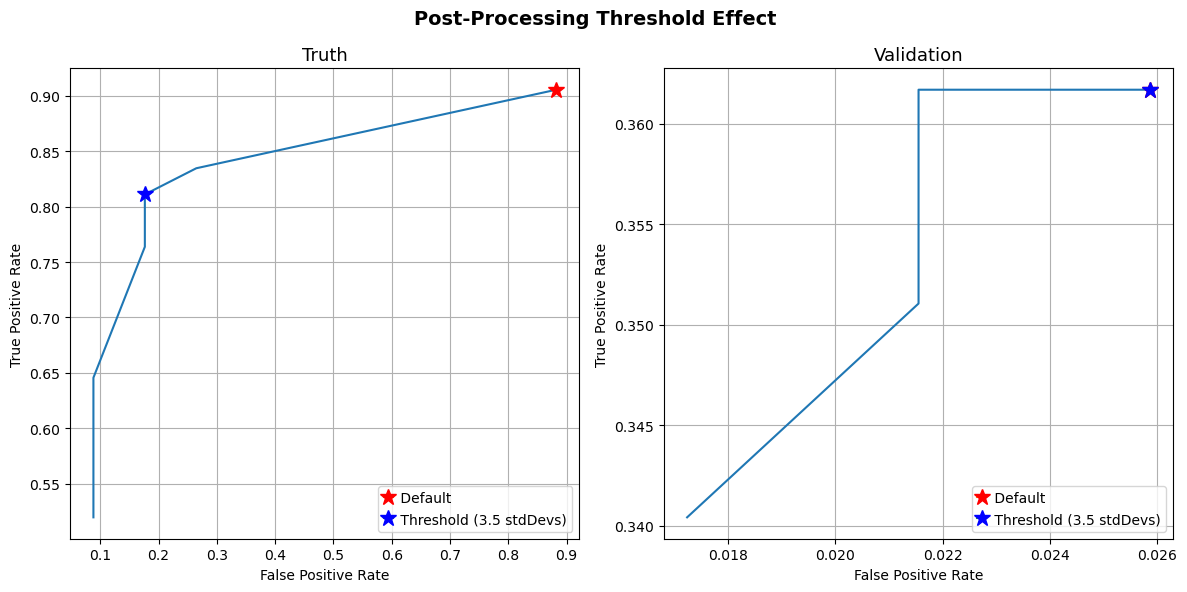

In [12]:
plot_threshold_effect("3-5")